In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer, ContourPlot
import numpy as np
import xarray as xr

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)
plot_time = datetime(2024, 10, 17, 18)

ht700 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=700)[0]
u700 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=700)[0]
v700 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=700)[0]
tmp700 = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=700)[0]

ht700 = ht700 * units('m')
u700 = u700 * units('m/s')
v700 = v700 * units('m/s')
tmp700 = tmp700 * units('K')

ht700 = mpcalc.smooth_gaussian(ht700, 16)
u700 = mpcalc.smooth_gaussian(u700, 16)
v700 = mpcalc.smooth_gaussian(v700, 16)
tmp700 = mpcalc.smooth_gaussian(tmp700, 16)

hAdv = mpcalc.advection(tmp700, u700, v700)

In [3]:
hTempAdv_neg = ContourPlot()
hTempAdv_neg.data = hAdv
hTempAdv_neg.time = plot_time
hTempAdv_neg.contours = np.arange(-15, -1, 2).tolist()
hTempAdv_neg.linecolor = 'black'
hTempAdv_neg.linestyle = 'dashed'
hTempAdv_neg.clabels = True
hTempAdv_neg.scale = 1e5
hTempAdv_neg.plot_units = 'K/s'

hTempAdv_pos = ContourPlot()
hTempAdv_pos.data = hAdv
hTempAdv_pos.time = plot_time
hTempAdv_pos.contours = np.arange(1, 32, 2).tolist()
hTempAdv_pos.linecolor = 'darkcyan'
hTempAdv_pos.linestyle = 'solid'
hTempAdv_pos.clabels = True
hTempAdv_pos.scale = 1e5
hTempAdv_pos.plot_units = 'K/s'

panel1 = MapPanel()
panel1.area = [-100, -70, 25, 50]
panel1.projection = 'lcc'
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'Horizontal Temperature Advection at 700mb at {plot_time}'
panel1.plots = [hTempAdv_neg, hTempAdv_pos]
panel1.layout = (2, 2, 1)

In [4]:
pressure = 700 
htpressure = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0] * units('m')

geoV0u, geoV0v = mpcalc.geostrophic_wind(htpressure)

geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geopressure = xr.merge([geoV0u,geoV0v])

tmpk = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=pressure)[0]
hght = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0]

tmpk_smooth = mpcalc.smooth_gaussian(tmpk, 16)
hght_smooth = mpcalc.smooth_gaussian(hght, 16)

geoV0u, geoV0v = mpcalc.geostrophic_wind(hght_smooth)

geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geopressure = xr.merge([geoV0u,geoV0v])


tmpk = tmpk * units('degK')
hght = hght * units('m')

temp_adv = mpcalc.advection(tmpk_smooth,geoV0u,geoV0v)
laplacian_temp = mpcalc.laplacian(temp_adv.squeeze(['time','pres']) )
laplacian = -R / pressure * laplacian_temp
total = laplacian

In [5]:
ETA_neg = ContourPlot()
ETA_neg.data = total
ETA_neg.contours = np.arange(-15, -1, 2).tolist()
ETA_neg.scale = 1e16
ETA_neg.linecolor = 'blue'
ETA_neg.linestyle = 'dashed'
ETA_neg.clabels = True


ETA_pos = ContourPlot()
ETA_pos.data = total
ETA_pos.contours = np.arange(1, 32, 2).tolist()
ETA_pos.scale = 1e16
ETA_pos.linecolor = 'red'
ETA_pos.linestyle = 'solid'
ETA_pos.clabels = True

panel2 = panel1.copy()
panel2.title = f'Entire Temperature Advection at 700mb at {plot_time}'
panel2.plots = [ETA_neg, ETA_pos]
panel2.layout = (2, 2, 2)

In [6]:
p1 = 850
p2 = 500
f0 = 1.028e-4

plot_time = datetime(2024, 10, 16, 18)

htp1 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p1)[0]
up1 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p1)[0]
vp1 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p1)[0]

htp2 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=p2)[0]
up2 = gem_file.gdxarray(parameter='UREL', date_time=plot_time, level=p2)[0]
vp2 = gem_file.gdxarray(parameter='VREL', date_time=plot_time, level=p2)[0]

htp1 = htp1 * units('m')
up1 = up1 * units('m/s')
vp1 = vp1 * units('m/s')

htp2 = htp2 * units('m')
up2 = up2 * units('m/s')
vp2 = vp2 * units('m/s')
16
htp1 = mpcalc.smooth_gaussian(htp1, 16)
htp2 = mpcalc.smooth_gaussian(htp2, 16)
up1 = mpcalc.smooth_gaussian(up1, 16)
vp1 = mpcalc.smooth_gaussian(vp1, 16)
up2 = mpcalc.smooth_gaussian(up2, 16)
vp2 = mpcalc.smooth_gaussian(vp2, 16)

up1_geo, vp1_geo = mpcalc.geostrophic_wind(htp1)
up2_geo, vp2_geo = mpcalc.geostrophic_wind(htp2)

absvor_p1 = mpcalc.absolute_vorticity(up1_geo, vp1_geo)
absvor_p2 = mpcalc.absolute_vorticity(up2_geo, vp2_geo)

advp1 = mpcalc.advection(absvor_p1, up1_geo, vp1_geo)
advp2 = mpcalc.advection(absvor_p2, up2_geo, vp2_geo)

term1 = f0 / ((p2-p1))

term2 = advp1.squeeze('pres') - advp2.squeeze('pres')

finalterm = term1 * term2

In [7]:
DVA_neg = ContourPlot()
DVA_neg.data = finalterm
DVA_neg.time = plot_time
DVA_neg.contours = range(-24,-1,2)
DVA_neg.scale = 1e16
DVA_neg.linecolor = 'maroon'
DVA_neg.linestyle = 'solid'
DVA_neg.plot_units = '1/s**2'

DVA_pos = ContourPlot()
DVA_pos.data = finalterm
DVA_pos.time = plot_time
DVA_pos.contours = range(1,25,2)
DVA_pos.scale = 1e16
DVA_pos.linecolor = 'darkcyan'
DVA_pos.linestyle = 'dashed'
DVA_pos.plot_units = '1/s**2'

panel3 = MapPanel()
panel3.area = [-100, -70, 25, 50]
panel3.projection = 'lcc'
panel3.layers = ['states', 'coastline', 'borders']
panel3.title = f'Differential Vorticity Advection Term Between {p2}mb & {p1}mb at {plot_time}'
panel3.plots = [DVA_neg, DVA_pos]
panel3.layout = (2, 2, 3)

In [8]:
total_no_units = total.metpy.dequantify()
finalterm_no_units = finalterm.metpy.dequantify()

omega = total_no_units + finalterm_no_units

omega = omega * units('microbar/second')

omega = mpcalc.smooth_gaussian(omega, 16)

In [10]:
heights = ContourPlot()
heights.data = ht700
heights.time = plot_time
heights.contours = list(range(0,600,3))
heights.linecolor = 'darkgreen'
heights.linestyle = 'solid'
heights.clabels = True
heights.plot_units = 'dam'

neg_omega = FilledContourPlot()
neg_omega.data = omega
neg_omega.time = plot_time
neg_omega.contours = list(range(0, 22, 2))
neg_omega.scale = 1e16
neg_omega.colormap = 'coolwarm'
neg_omega.colorbar = 'horizontal'

panel4 = panel3.copy()
panel4.title = f'Negative Omega at 700mb & 700mb Heights at {plot_time}'
panel4.plots = [heights, neg_omega]
panel4.layout = (2, 2, 4)

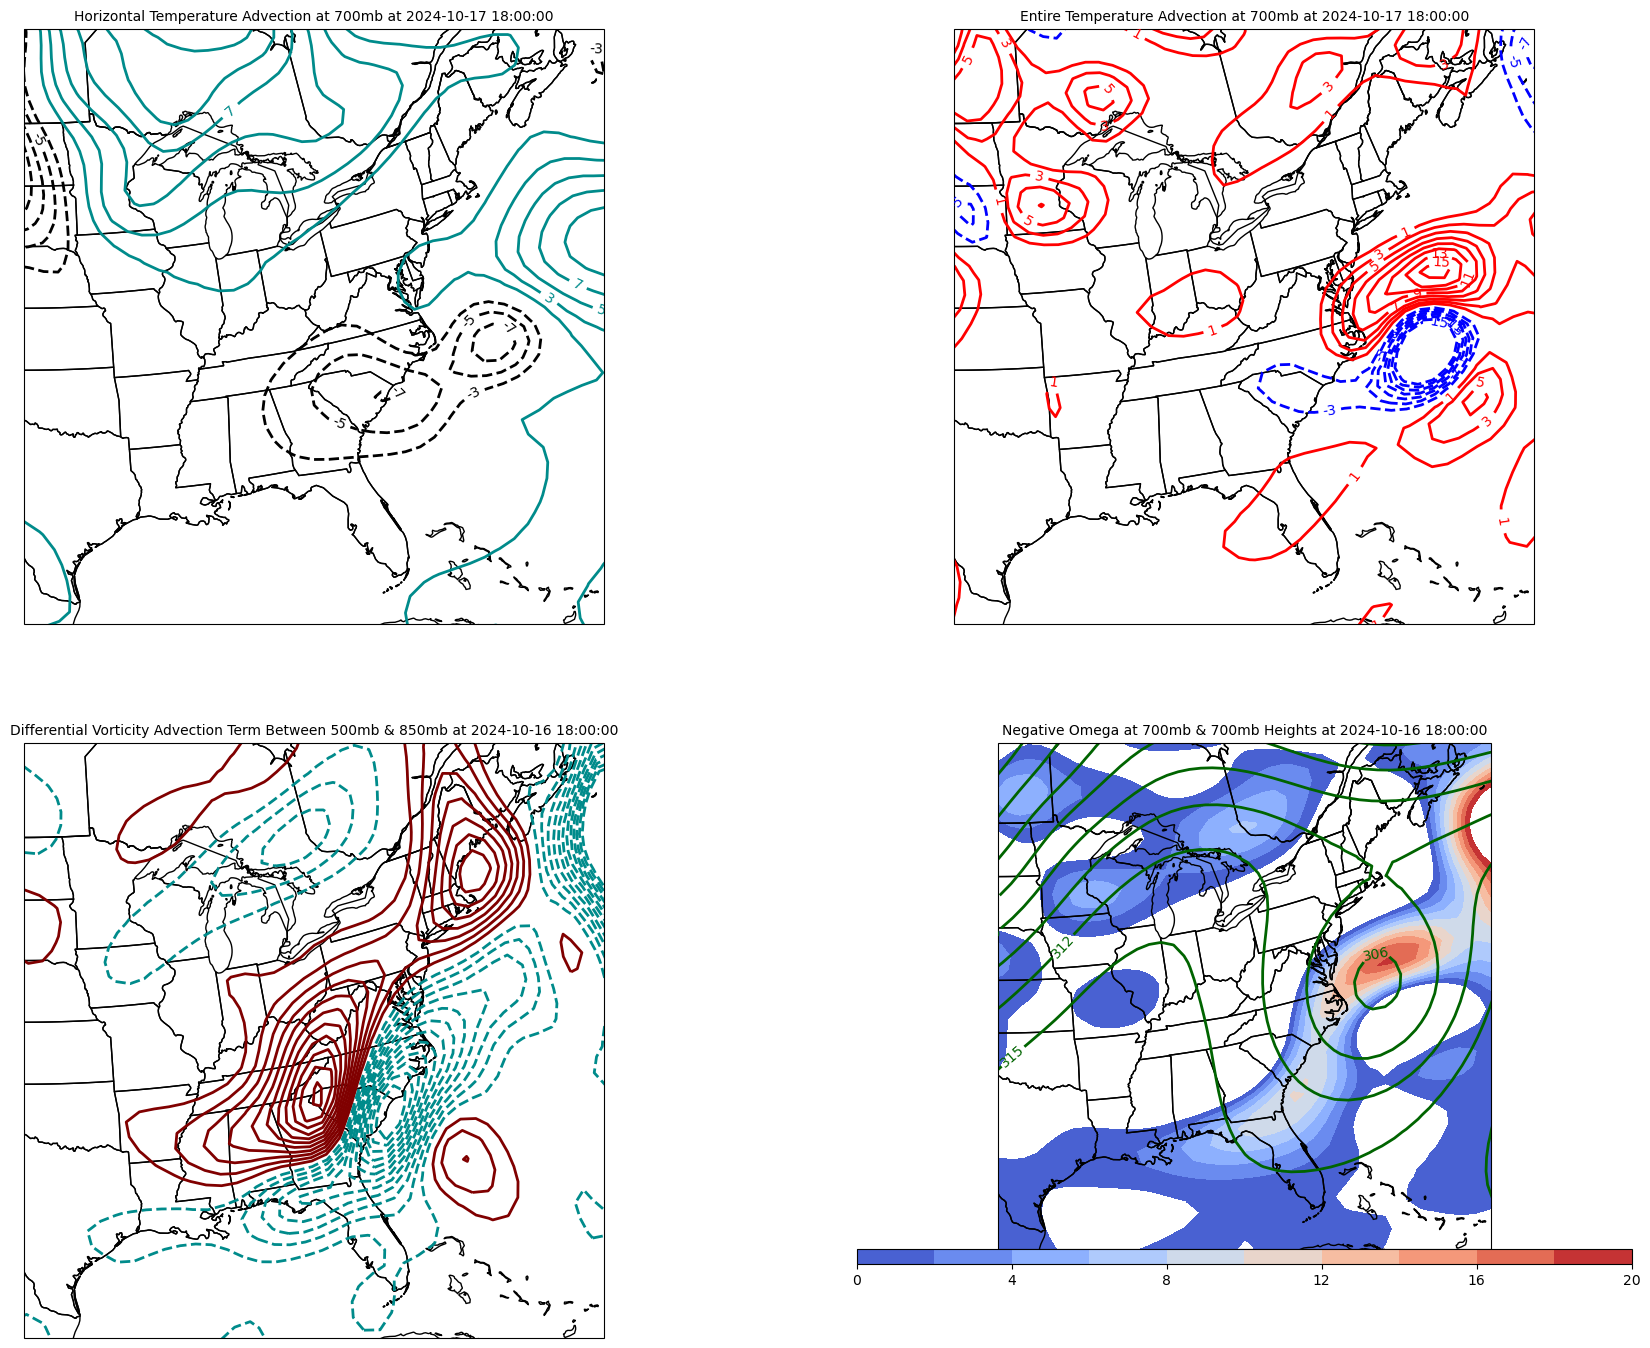

In [11]:
pc = PanelContainer()
pc.size = (22,17)
pc.panels = [panel1, panel2, panel3, panel4]
pc.show()